<a href="https://colab.research.google.com/github/kkt86/quant-notebooks/blob/master/mean_reversion_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
### installs
%%bash

pip install backtrader yahoofinance hurst

In [0]:
%%bash
cat > /usr/local/lib/python3.6/dist-packages/backtrader/plot/__init__.py  <<'endmessage'
#!/usr/bin/env python
# -*- coding: utf-8; py-indent-offset:4 -*-
###############################################################################
#
# Removed bug to make it work in colab
#
###############################################################################
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

try:
    import matplotlib
except Exception:
    pass
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [19, 10]

from .plot import Plot, Plot_OldSync
from .scheme import PlotScheme
endmessage

# Research

In [78]:
# pull data from Yahoo Finance

import yahoofinance as yf
import pandas as pd

%matplotlib inline

symbol = "GS"
result = yf.HistoricalPrices(symbol, "2010-01-01", "2020-01-01")
raw_data = result.to_dfs()["Historical Prices"]
raw_data.index = pd.to_datetime(raw_data.index)

raw_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,170.050003,174.250000,169.509995,173.080002,150.662186,9135000
2010-01-05,173.000000,176.259995,172.570007,176.139999,153.325790,11659400
2010-01-06,175.380005,175.380005,173.759995,174.259995,151.689255,7381100
2010-01-07,174.320007,178.750000,173.949997,177.669998,154.657593,8727400
2010-01-08,176.330002,177.429993,173.949997,174.309998,151.732819,7268100


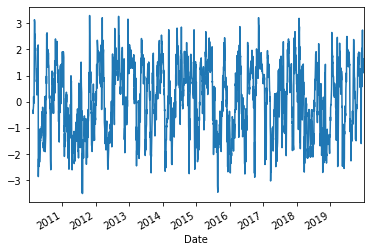

In [79]:
# compute z-score
data = raw_data.copy()

window=30

data["Mean"] = data["Close"].rolling(window).mean()
data["Std"] = data["Close"].rolling(window).std()
data["Z score"] = (data["Close"] - data["Mean"])/data["Std"]

data["Z score"].plot()

In [0]:
import numpy as np

def hurst(ts):
  if len(ts) <= 100:
    return None
  else:
    try:
      lags = range(2, 100)
      tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
      poly = np.polyfit(np.log(lags), np.log(tau), 1)
      return poly[0]*2.0
    except Exception:
      return None

In [80]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Mean,Std,Z score
Date,,,,,,,,,
2010-01-04,170.050003,174.250000,169.509995,173.080002,150.662186,9135000,NaN,NaN,NaN
2010-01-05,173.000000,176.259995,172.570007,176.139999,153.325790,11659400,NaN,NaN,NaN
2010-01-06,175.380005,175.380005,173.759995,174.259995,151.689255,7381100,NaN,NaN,NaN
2010-01-07,174.320007,178.750000,173.949997,177.669998,154.657593,8727400,NaN,NaN,NaN
2010-01-08,176.330002,177.429993,173.949997,174.309998,151.732819,7268100,NaN,NaN,NaN


# Backtrading

In [0]:
import backtrader as bt
import backtrader.plot
import matplotlib
matplotlib.use('agg')

In [0]:
# define pandas data feed
class YFPandasData(bt.feeds.PandasData):
    params = (
        ("datetime", None),
        ("open", "Open"),
        ("high", "High"),
        ("low", "Low"),
        ("close", "Close"),
        ("volume", "Volume"),
        ('openinterest', None),
    )

In [0]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# define strategy
class MeanReversionStrategy(bt.Strategy):
  params = dict(
      window=60,
      printout=True
  )

  def __init__(self):
    mean = bt.ind.SMA(period=self.p.window)
    std = bt.ind.StandardDeviation(period=self.p.window)
    self.z_score = (self.datas[0].close - mean)/std

  def log(self, txt, dt=None):
    if self.p.printout:
      dt = dt or self.data.datetime[0]
      dt = bt.num2date(dt)
      print('%s, %s' % (dt.isoformat(), txt))

  def _hurst(self, ts):
    if len(ts) <= 100:
      return None
    else:
      try:
        lags = range(2, 100)
        tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return poly[0]*2.0
      except Exception:
        return None
  
  def next(self):

    # get closing price values as list (most recent value is the last one)
    close_prices = self.data.close.get(size=150).tolist()
    if len(close_prices) == 150:
      hurst = self._hurst(close_prices)
      if hurst:
        self.log(f"Hurst exponent: {hurst}")

  

  


    
    

In [0]:
import backtrader as bt

# set up cerebro
cerebro = bt.Cerebro()
cerebro.broker.set_cash(10000.0)
cerebro.broker.setcommission(commission=0.001)

# add data feed
data_feed = YFPandasData(dataname=data, name=symbol)
cerebro.adddata(data_feed)

# run strategy
cerebro.addstrategy(MeanReversionStrategy)
cerebro.run()




[[<Figure size 1368x720 with 5 Axes>]]

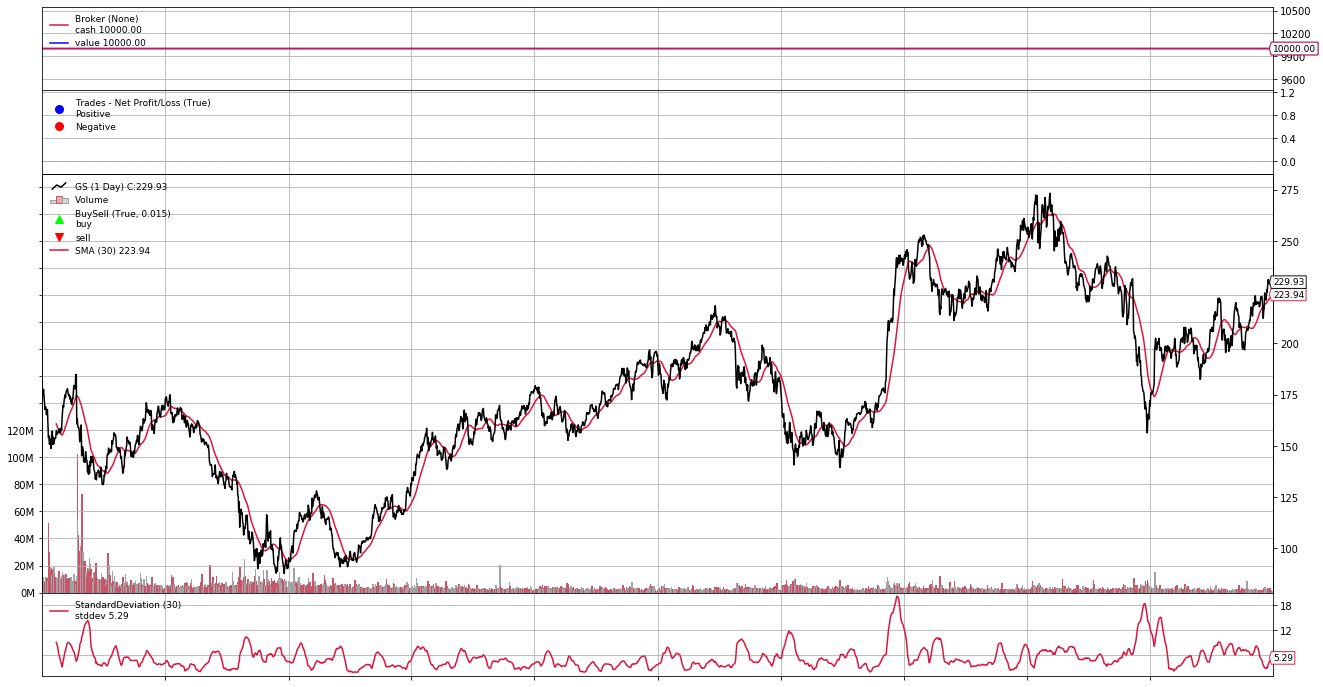

In [102]:
cerebro.plot(iplot=False)